In [1]:
import pandas as pd
import numpy as np
import requests
from io import StringIO
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

In [2]:
path = 'Dataset/Detail_listings.csv'
df = pd.read_csv(path)

/Users/zhaoxuanyi/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (87) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,16228948,https://www.airbnb.com/rooms/16228948,20170502172350,2017-05-03,Robert Ranch in Los Angeles for filming/wedding,Stunning Ranch Estate situated on 20 acres and...,NaN,Stunning Ranch Estate situated on 20 acres and...,none,NaN,...,NaN,f,NaN,NaN,t,strict,f,f,1,NaN
1,8909380,https://www.airbnb.com/rooms/8909380,20170502172350,2017-05-03,Nice quiet private ranch house,NaN,Very private and quite . Hiking horse riding a...,Very private and quite . Hiking horse riding a...,none,I'm in the country what's not to love about that,...,9.0,f,NaN,NaN,f,flexible,f,f,1,1.91
2,14078522,https://www.airbnb.com/rooms/14078522,20170502172350,2017-05-03,Room w/private bath on Small Ranch,My place is close to Six Flags Magic Mountain ...,Room with queen bed and private bath,My place is close to Six Flags Magic Mountain ...,none,Horse area. Trails for hiking and riding. Quie...,...,10.0,f,NaN,NaN,f,flexible,f,f,1,1.72
3,13006928,https://www.airbnb.com/rooms/13006928,20170502172350,2017-05-03,Miller Ranch Bunkhouse,"Our place is close to great views, equestrian ...",Please know that we live on a dirt road but it...,"Our place is close to great views, equestrian ...",none,NaN,...,10.0,f,NaN,NaN,t,flexible,f,f,1,2.12
4,7898757,https://www.airbnb.com/rooms/7898757,20170502172350,2017-05-03,Studio with full bathroom,Fully furnished studio only a 10 min drive fro...,NaN,Fully furnished studio only a 10 min drive fro...,none,NaN,...,10.0,f,NaN,"City of Los Angeles, CA",f,flexible,f,f,1,0.18


In [88]:
useful_df = df[['host_is_superhost', 'host_response_time', 'host_response_rate', 'review_scores_rating','latitude', 
                'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 
                'beds', 'bed_type', 'amenities', 'price', 'number_of_reviews', 'cancellation_policy']]

In [89]:
def nullify(x):
    if x == '{}':
        return np.nan
    else:
        return x

In [90]:
useful_df = useful_df.applymap(nullify)
clean_df = useful_df.dropna(axis = 0).reset_index(drop = True)
examples, features = clean_df.shape

In [91]:
clean_df.head()

,host_is_superhost,host_response_time,host_response_rate,review_scores_rating,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,number_of_reviews,cancellation_policy
0,t,within an hour,100%,100.0,34.510130,-118.212407,t,House,Private room,2,1.0,1.0,1.0,Real Bed,"{""Wireless Internet"",""Air conditioning"",""Wheel...",$55.00,14,flexible
1,t,within an hour,100%,100.0,34.515486,-118.230742,t,Other,Entire home/apt,6,1.0,1.0,3.0,Real Bed,"{TV,""Wireless Internet"",""Air conditioning"",Poo...",$150.00,22,flexible
2,t,within a few hours,96%,98.0,34.032502,-118.297748,t,House,Private room,2,1.0,1.0,1.0,Real Bed,"{Internet,""Wireless Internet"",""Free parking on...",$45.00,38,moderate
3,t,within an hour,100%,99.0,34.027019,-118.302472,t,House,Private room,2,1.5,1.0,2.0,Real Bed,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",$80.00,42,moderate
4,f,within a day,80%,99.0,34.030401,-118.307196,t,Guesthouse,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",""Air conditio...",$120.00,15,moderate


In [92]:
amenities_df = clean_df['amenities']
amenities_list = []
amenities_num = {}
for item in amenities_df:
    item = item.lstrip('{')
    item = item.rstrip('}')
    item = item.replace('"', '')
    item_list = item.split(',')
    for i in item_list:
        if i in amenities_num:
            amenities_num[i] += 1
        else:
            amenities_num[i] = 0
    amenities_list.append(item_list)

In [93]:
import operator
sorted_amen = sorted(amenities_num.items(), key = operator.itemgetter(1), reverse = True)
sorted_amenities_num = {}

# Select the amenities which are available for at least 10000 examples (about 50% of all data set)
for (i, j) in sorted_amen:
    if (i == 'translation missing: en.hosting_amenity_50') or (i == 'translation missing: en.hosting_amenity_49') or j < 10000:
        continue
    else:
        sorted_amenities_num[i] = j

In [94]:
key_num = len(sorted_amenities_num.keys())
amen_array = np.zeros([examples, key_num], dtype = int)
for idx, i in enumerate(clean_df['amenities']):
    for idx_2, j in enumerate(sorted_amenities_num.keys()):
         if j in i:
                amen_array[idx, idx_2] = 1

In [95]:
clean_amenities_df = pd.DataFrame(amen_array, columns = sorted_amenities_num.keys())
clean_df_add_amenities = pd.concat([clean_df, clean_amenities_df], axis = 1)

In [96]:
# Drop the % symbol in the column of host_response_rate and change the data type to numerical
clean_response_rate = []
for i in range(examples):
    old_item = clean_df_add_amenities['host_response_rate'][i]
    clean_response_rate.append(float(old_item.rstrip('%')))

clean_df_add_amenities['host_response_rate'] = clean_response_rate

In [97]:
# Drop the $ symbol in the column of price and change the data type to numerical
clean_df_add_amenities = clean_df_add_amenities.drop(columns = 'amenities')
clean_price = []
for i in range(examples):
    old_item = clean_df_add_amenities['price'][i]
    old_item = old_item.replace(',', '')
    clean_price.append(float(old_item.lstrip('$')))

clean_df_add_amenities['price'] = clean_price


In [98]:
clean_df_add_amenities = clean_df_add_amenities.drop(columns = ['Internet'])

In [99]:
clean_df_add_amenities.describe()
# According to the description of data, drop the abnormal values in the data set.

,host_response_rate,review_scores_rating,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,number_of_reviews,...,Hangers,Dryer,Air conditioning,Carbon monoxide detector,Hair dryer,Free parking on premises,Laptop friendly workspace,Iron,Family/kid friendly,Fire extinguisher
count,21092.000000,21092.000000,21092.000000,21092.000000,21092.000000,21092.000000,21092.000000,21092.000000,21092.000000,21092.000000,...,21092.000000,21092.000000,21092.000000,21092.000000,21092.000000,21092.00000,21092.000000,21092.000000,21092.000000,21092.000000
mean,95.784184,94.312630,34.055099,-118.334548,3.542907,1.355514,1.327043,1.943012,152.385549,29.843116,...,0.747772,0.741513,0.716006,0.688318,0.679452,0.67656,0.662811,0.650863,0.597098,0.488716
std,13.103954,7.518026,0.100136,0.151826,2.456739,0.760024,0.955410,1.551076,230.345055,42.976525,...,0.434302,0.437813,0.450945,0.463192,0.466698,0.46780,0.472761,0.476709,0.490493,0.499885
min,0.000000,20.000000,33.338905,-118.911026,1.000000,0.000000,0.000000,1.000000,10.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,100.000000,92.000000,34.010394,-118.431560,2.000000,1.000000,1.000000,1.000000,69.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,100.000000,96.000000,34.066070,-118.348031,3.000000,1.000000,1.000000,1.000000,100.000000,14.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,0.000000
75%,100.000000,100.000000,34.102975,-118.267246,4.000000,1.500000,2.000000,2.000000,165.000000,37.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000
max,100.000000,100.000000,34.732700,-117.655471,16.000000,8.000000,10.000000,16.000000,10000.000000,605.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000


In [ ]:
wrangling_df = clean_df_add_amenities[clean_df_add_amenities['price'] <= 600].reset_index(drop = True)
wrangling_df = wrangling_df[wrangling_df['number_of_reviews'] > 5].reset_index(drop = True)

regression_data = pd.get_dummies(wrangling_df)
# regression_X = regression_data.drop(columns = ['review_scores_rating', 
#                                                'price'])

# regression_Y = regression_data[['review_scores_rating',  
#                                 'price']]

# Calculate the nearby average price for each house

In [ ]:
tmp_df = wrangling_df[['latitude', 'longitude', 'price']]
ones_col = np.ones([len(tmp_df), 1], dtype = int)
tmp_df = pd.concat([tmp_df, pd.DataFrame(ones_col, columns = ['oneone'])], axis = 1)
tmp_df.shape

In [ ]:
calculate_df = tmp_df.merge(tmp_df, left_on = 'oneone', right_on = 'oneone', how = 'inner')

In [ ]:
calculate_df['lat_y-lat_x'] = calculate_df['latitude_y'] - calculate_df['latitude_x']

In [ ]:
calculate_df['lon_y-lon_x'] = calculate_df['longitude_y'] - calculate_df['longitude_x']

In [ ]:
import math
def radian_convert(number):
    return math.radians(number)

In [ ]:
change1 = calculate_df['latitude_x']
change2 = calculate_df['longitude_x']
change3 = calculate_df['latitude_y']
change4 = calculate_df['longitude_y']
change5 = calculate_df['lat_y-lat_x']
change6 = calculate_df['lon_y-lon_x']

change_df = pd.concat([change1, change2, change3, change4, change5, change6], axis = 1)

In [ ]:
applied_df = change_df.applymap(radian_convert)

In [ ]:
applied_mat = applied_df.values
step1_result = (np.sin(applied_mat[:,4]/2))**2 + np.cos(applied_mat[:,0])*np.cos(applied_mat[:,2])*(np.sin(applied_mat[:,5]/2))**2
R = 6372800
step2_result = 2 * R * np.arctan(np.sqrt(step1_result), np.sqrt(1 - step1_result))


In [ ]:
distance_result_in_mile = step2_result / 1609.34
distance_value = pd.DataFrame(distance_result_in_mile, columns = ['distance'])

In [ ]:
clean_calculate_df = calculate_df.drop(columns = ['oneone', 'lat_y-lat_x', 'lon_y-lon_x'])

In [ ]:
distance_df = pd.concat([clean_calculate_df, distance_value], axis = 1)

In [ ]:
# distance_df.to_csv('distance.csv', sep='\t')

In [ ]:
distance_in_2mile_df = distance_df[distance_df['distance'] < 2]

In [ ]:
# distance_in_2mile_df.to_csv('distance_in2mile.csv', sep='\t')

In [ ]:
mean_distance = distance_in_2mile_df.groupby(['latitude_x', 'longitude_x', 'price_x'])['price_y'].mean()

In [ ]:
mean_distance_df = pd.DataFrame(mean_distance)
mean_distance_df = mean_distance_df.reset_index()
mean_distance_df = mean_distance_df[mean_distance_df['price_x'] != mean_distance_df['price_y']]
mean_distance_df = mean_distance_df.drop(columns = ['price_x'])
mean_distance_df.columns = ['latitude', 'longitude', 'neighbor_price']

In [ ]:
merged_regression = regression_data.merge(mean_distance_df, how = 'left', left_on = ['latitude', 'longitude'], right_on = ['latitude', 'longitude'])
merged_regression = merged_regression.dropna(axis = 0).reset_index(drop = True)

In [ ]:
merged_regression.shape

In [ ]:
merged_classification = classification_data.merge(mean_distance_df, how = 'left', left_on = ['latitude', 'longitude'], right_on = ['latitude', 'longitude'])
merged_classification = merged_classification.dropna(axis = 0).reset_index(drop = True)

In [ ]:
merged_classification.shape

# Plot the correlation matrix

In [84]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix', fontsize=15)
    plt.show()

In [109]:
mean_distance = pd.concat([merged_regression['latitude'],merged_regression['longitude'],merged_regression['neighbor_price']], axis = 1)


In [120]:
merged_plot = wrangling_df.merge(mean_distance, how = 'left', left_on = ['latitude', 'longitude'], right_on = ['latitude', 'longitude'])
merged_plot = merged_plot.dropna(axis = 0).reset_index(drop = True)

In [121]:
merged_plot['host_response_time'] = merged_plot['host_response_time'].replace({'within an hour': 0,
                                                                               'within a few hours': 1, 
                                                                               'within a day': 2, 
                                                                               'a few days or more': 3})
merged_plot['host_is_superhost'] = merged_plot['host_is_superhost'].replace({'t': 1, 'f': 0})
merged_plot['is_location_exact'] = merged_plot['is_location_exact'].replace({'t': 1, 'f': 0})
merged_plot['property_type'] = merged_plot['property_type'].replace({  'Other': 0,
                                                                       'House': 1, 
                                                                       'Guesthouse': 2, 
                                                                       'Apartment': 3, 
                                                                       'Townhouse': 4,
                                                                       'Bed & Breakfast': 5, 
                                                                       'Dorm': 6, 
                                                                       'Loft': 7,
                                                                       'Condominium': 8, 
                                                                       'Villa': 9, 
                                                                       'Bungalow': 10, 
                                                                       'Cabin': 11, 
                                                                       'Camper/RV': 12, 
                                                                       'Island': 13, 
                                                                       'Hostel': 14, 
                                                                       'Guest suite': 15, 
                                                                       'Serviced apartment': 16, 
                                                                       'Plane': 17, 
                                                                       'Tent': 18, 
                                                                       'Boat': 19, 
                                                                       'Boutique hotel': 20, 
                                                                       'Yurt': 21, 
                                                                       'Castle': 22,
                                                                       'In-law': 23, 
                                                                       'Tipi': 24, 
                                                                       'Chalet': 25,
                                                                       'Earth House': 26, 
                                                                       'Hut': 27, 
                                                                       'Treehouse': 28, 
                                                                       'Train': 29, 
                                                                       'Cave': 30})
merged_plot['room_type'] = merged_plot['room_type'].replace({'Private room': 0,
                                                             'Entire home/apt': 1, 
                                                             'Shared room': 2})
merged_plot['bed_type'] = merged_plot['bed_type'].replace({'Real Bed': 0,
                                                           'Futon': 1, 
                                                           'Airbed': 2, 
                                                           'Pull-out Sofa': 3,
                                                           'Couch': 4})
merged_plot['cancellation_policy'] = merged_plot['cancellation_policy'].replace({'flexible': 0,
                                                                                 'moderate': 1, 
                                                                                 'strict': 2, 
                                                                                 'super_strict_60': 3})

In [126]:
price_col = merged_plot['price']
merged_plot = merged_plot.drop(columns = ['price'])
merged_plot = pd.concat([merged_plot, pd.DataFrame(price_col, columns = ['price'])], axis = 1)

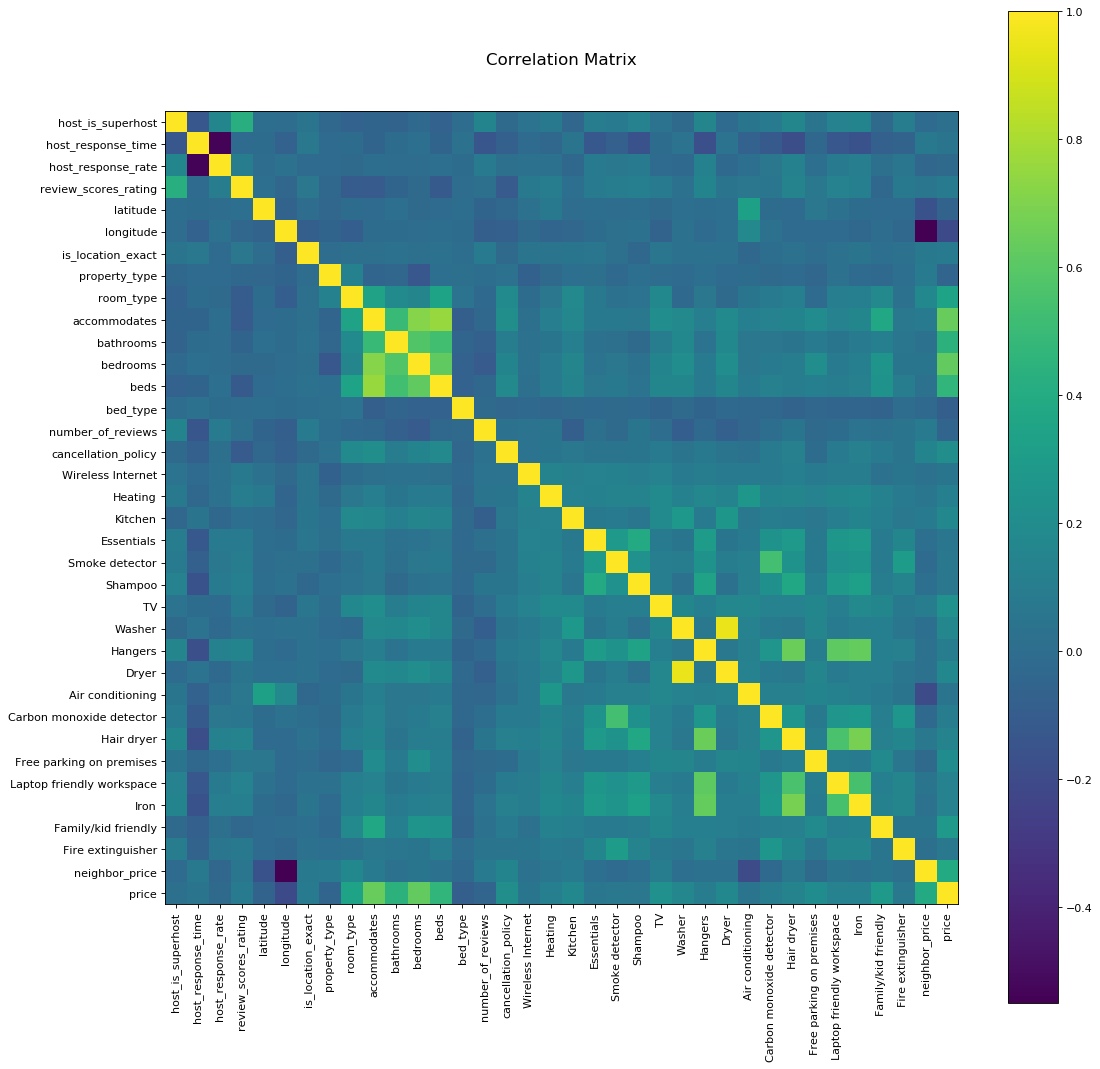

In [127]:
plotCorrelationMatrix(merged_plot, 16)


In [4]:
path1 = 'regression.csv'
path2 = 'classification.csv'
merged_regression = pd.read_csv(path1, sep = '\t')
merged_classification = pd.read_csv(path2, sep = '\t')
merged_regression = merged_regression.drop(columns = ['Unnamed: 0'])
merged_classification = merged_classification.drop(columns = ['Unnamed: 0'])


In [5]:
regression_X = merged_regression.drop(columns = ['review_scores_rating', 
                                                 'price'])

regression_Y = merged_regression[['review_scores_rating',  
                                  'price']]

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(regression_X, regression_Y, test_size = 0.20)

In [7]:
m, d = X_train.shape

In [8]:
X_train.shape

(11790, 79)